**This notebook is an exercise in the [Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/missing-values).**

---


Now it's your turn to test your new knowledge of **missing values** handling. You'll probably find it makes a big difference.

# Setup

The questions will give you feedback on your work. Run the following cell to set up the feedback system.

In [1]:
# Set up code checking
import os
if not os.path.exists("../input/train.csv"):
    os.symlink("../input/home-data-for-ml-course/train.csv", "../input/train.csv")  
    os.symlink("../input/home-data-for-ml-course/test.csv", "../input/test.csv") 
from learntools.core import binder
binder.bind(globals())
from learntools.ml_intermediate.ex2 import *
print("Setup Complete")

Setup Complete


In this exercise, you will work with data from the [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/c/home-data-for-ml-course). 

![Ames Housing dataset image](https://i.imgur.com/lTJVG4e.png)

Run the next code cell without changes to load the training and validation sets in `X_train`, `X_valid`, `y_train`, and `y_valid`.  The test set is loaded in `X_test`.

1장에서 배운 것과 동일하기에 생략합니다.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('../input/train.csv', index_col='Id')
X_test_full = pd.read_csv('../input/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# To keep things simple, we'll use only numerical predictors
X = X_full.select_dtypes(exclude=['object'])
X_test = X_test_full.select_dtypes(exclude=['object'])

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

Use the next code cell to print the first five rows of the data.

In [3]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
619,20,90.0,11694,9,5,2007,2007,452.0,48,0,...,774,0,108,0,0,260,0,0,7,2007
871,20,60.0,6600,5,5,1962,1962,0.0,0,0,...,308,0,0,0,0,0,0,0,8,2009
93,30,80.0,13360,5,7,1921,2006,0.0,713,0,...,432,0,0,44,0,0,0,0,8,2009
818,20,NaN,13265,8,5,2002,2002,148.0,1218,0,...,857,150,59,0,0,0,0,0,7,2008
303,20,118.0,13704,7,5,2001,2002,150.0,0,0,...,843,468,81,0,0,0,0,0,1,2006


# 결측치 3 approaches

1)  A Simple Option: Drop Columns with Missing Values
  - 결측치가 존재하는 column(열)삭제

2) A Better Option: Imputation
   - 결측값 대체 : 정확한 방법은 아니지만, 1) 방식보다 더 accurate model을 도출하기도 합니다.
   
3) An Extension To Imputation
   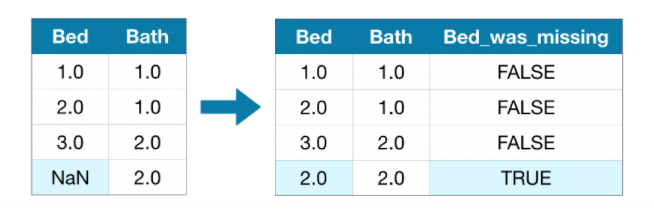
   - 결측값 대체에서 왜곡되는 것들에 대해서 새로운 column을 추가하여 결측치라고 알려주는 방법입니다. (결측치 대체의 확장)

You can already see a few missing values in the first several rows.  In the next step, you'll obtain a more comprehensive understanding of the missing values in the dataset.
<br>
- head()를 찍은 결과 결측치가 존재

# Step 1: Preliminary investigation

Run the code cell below without changes.

In [4]:
# Shape of training data (num_rows, num_columns)
print(X_train.shape)

# Number of missing values in each column of training data
#결측치가 있는 경우에 대해 수를 출력
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(1168, 36)
LotFrontage    212
MasVnrArea       6
GarageYrBlt     58
dtype: int64


### Part A

Use the above output to answer the questions below.

In [8]:
# Fill in the line below: How many rows are in the training data?
num_rows = 1168

# Fill in the line below: How many columns in the training data
# have missing values?
num_cols_with_missing = 3

# Fill in the line below: How many missing entries are contained in 
# all of the training data?
tot_missing = 212+6+58

# Check your answers
step_1.a.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [10]:
# Lines below will give you a hint or solution code
#step_1.a.hint()
#step_1.a.solution()

### Part B
Considering your answers above, what do you think is likely the best approach to dealing with the missing values?
가장 좋은 접근법은 무엇일까??

- 해당 결측이 존재하는 column에서의 결측치가 전체 개수의 20% 미만으로 column 자체를 삭제한다면 매우 데이터 손실이 큼
- 따라서, 결측행 제거나 대체를 이용

In [11]:
# Check your answer (Run this code cell to receive credit!)
step_1.b.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

Since there are relatively few missing entries in the data (the column with the greatest percentage of missing values is missing less than 20% of its entries), we can expect that dropping columns is unlikely to yield good results.  This is because we'd be throwing away a lot of valuable data, and so imputation will likely perform better.

In [13]:
#step_1.b.hint()

To compare different approaches to dealing with missing values, you'll use the same `score_dataset()` function from the tutorial.  This function reports the [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) (MAE) from a random forest model.

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

# Step 2: Drop columns with missing values

In this step, you'll preprocess the data in `X_train` and `X_valid` to remove columns with missing values.  Set the preprocessed DataFrames to `reduced_X_train` and `reduced_X_valid`, respectively.  

# any 함수

any(iterable) 함수는 인자로 받은 반복가능한 자료형(iterable)중 단 하나라도 참(True)이 있으면 참(True)를 반환하는 함수<br>
반대로 모든 요소가 거짓(False)인 경우에만 거짓(False)을 반환

따라서, for문에서 true값만 반환하여 잘 사용됨!

[col for col in X_train.columns if X_train[col].isnull().any()]

In [32]:
# Fill in the line below: get names of columns with missing values
____ # Your code here

# Fill in the lines below: drop columns in training and validation data 결측치가 존재하는 열 삭제
isnull_col_list = [col for col in X_train.columns if X_train[col].isnull().any()]
reduced_X_train = X_train.drop(isnull_col_list, axis=1)
reduced_X_valid = X_valid.drop(isnull_col_list, axis=1)

# Check your answers
step_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [15]:
# Lines below will give you a hint or solution code
#step_2.hint()
#step_2.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

# Drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

```

Run the next code cell without changes to obtain the MAE for this approach.

In [33]:
print("MAE (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

MAE (Drop columns with missing values):
17837.82570776256


# Step 3: Imputation

### Part A

Use the next code cell to impute missing values with the mean value along each column.  Set the preprocessed DataFrames to `imputed_X_train` and `imputed_X_valid`.  Make sure that the column names match those in `X_train` and `X_valid`.


테스트할 때의 경우 훈련에서 사용했던 값들을 기반으로 transform() 메서드만 사용해 변환시켜야 함!!!! (중요)
- fit_transform(train_set) : 훈련 시
- transform(valid_set) :테스트 시

In [35]:
from sklearn.impute import SimpleImputer

# Fill in the lines below: imputation
imputer = SimpleImputer() # Your code here
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(imputer.transform(X_valid))

# Fill in the lines below: imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

# Check your answers
step_3.a.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [36]:
imputed_X_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20.0,90.000000,11694.0,9.0,5.0,2007.0,2007.0,452.0,48.0,0.0,...,774.0,0.0,108.0,0.0,0.0,260.0,0.0,0.0,7.0,2007.0
1,20.0,60.000000,6600.0,5.0,5.0,1962.0,1962.0,0.0,0.0,0.0,...,308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2009.0
2,30.0,80.000000,13360.0,5.0,7.0,1921.0,2006.0,0.0,713.0,0.0,...,432.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,8.0,2009.0
3,20.0,69.614017,13265.0,8.0,5.0,2002.0,2002.0,148.0,1218.0,0.0,...,857.0,150.0,59.0,0.0,0.0,0.0,0.0,0.0,7.0,2008.0
4,20.0,118.000000,13704.0,7.0,5.0,2001.0,2002.0,150.0,0.0,0.0,...,843.0,468.0,81.0,0.0,0.0,0.0,0.0,0.0,1.0,2006.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,60.0,82.000000,9430.0,8.0,5.0,1999.0,1999.0,673.0,1163.0,0.0,...,856.0,0.0,128.0,0.0,0.0,180.0,0.0,0.0,7.0,2009.0
1164,20.0,60.000000,9600.0,4.0,7.0,1950.0,1995.0,0.0,442.0,0.0,...,436.0,290.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2010.0
1165,90.0,68.000000,8930.0,6.0,5.0,1978.0,1978.0,0.0,0.0,0.0,...,539.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2010.0
1166,120.0,69.614017,3196.0,7.0,5.0,2003.0,2004.0,18.0,0.0,0.0,...,420.0,143.0,20.0,0.0,0.0,0.0,0.0,0.0,10.0,2006.0


In [37]:
imputed_X_valid

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20.0,69.614017,32668.0,6.0,3.0,1957.0,1975.0,103.481067,1219.0,0.0,...,484.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,3.0,2007.0
1,50.0,79.000000,9490.0,6.0,7.0,1941.0,1950.0,0.000000,403.0,165.0,...,240.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,8.0,2006.0
2,50.0,69.614017,7015.0,5.0,4.0,1950.0,1950.0,161.000000,185.0,0.0,...,352.0,0.0,0.0,248.0,0.0,0.0,0.0,0.0,7.0,2009.0
3,60.0,83.000000,10005.0,7.0,5.0,1977.0,1977.0,299.000000,392.0,0.0,...,505.0,288.0,117.0,0.0,0.0,0.0,0.0,0.0,3.0,2008.0
4,160.0,21.000000,1680.0,6.0,5.0,1971.0,1971.0,381.000000,0.0,0.0,...,264.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,120.0,32.000000,10846.0,8.0,5.0,1993.0,1993.0,0.000000,1619.0,0.0,...,473.0,122.0,30.0,0.0,0.0,0.0,0.0,0.0,5.0,2008.0
288,20.0,105.000000,15431.0,10.0,5.0,2008.0,2008.0,200.000000,1767.0,539.0,...,672.0,0.0,72.0,0.0,0.0,170.0,0.0,0.0,4.0,2009.0
289,50.0,60.000000,8520.0,6.0,7.0,1916.0,1950.0,0.000000,168.0,546.0,...,216.0,88.0,15.0,0.0,0.0,0.0,0.0,0.0,8.0,2007.0
290,30.0,50.000000,5330.0,4.0,7.0,1940.0,1950.0,0.000000,280.0,0.0,...,0.0,164.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2009.0


In [34]:
# Lines below will give you a hint or solution code
#step_3.a.hint()
#step_3.a.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

```

Run the next code cell without changes to obtain the MAE for this approach.

In [38]:
print("MAE (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE (Imputation):
18062.894611872147


### Part B

Compare the MAE from each approach.  Does anything surprise you about the results?  Why do you think one approach performed better than the other?

- 대체하는것보다 열을 삭제하는 것이 더효과적임!!
- 열의 누락된 결측치를 0으로 설정하여 오히려 비효율적이게 될 수 있기 때문이다.
- 연도의 경우 0이 들어가면 더 안 좋은 모델링이 될 수 밖에 없음 . 따라서 오히려 열을 삭제하는 것이 더 효과적임!!

In [39]:
# Check your answer (Run this code cell to receive credit!)
step_3.b.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

Given that thre are so few missing values in the dataset, we'd expect imputation to perform better than dropping columns entirely.  However, we see that dropping columns performs slightly better!  While this can probably partially be attributed to noise in the dataset, another potential explanation is that the imputation method is not a great match to this dataset.  That is, maybe instead of filling in the mean value, it makes more sense to set every missing value to a value of 0, to fill in the most frequently encountered value, or to use some other method.  For instance, consider the `GarageYrBlt` column (which indicates the year that the garage was built).  It's likely that in some cases, a missing value could indicate a house that does not have a garage.  Does it make more sense to fill in the median value along each column in this case?  Or could we get better results by filling in the minimum value along each column?  It's not quite clear what's best in this case, but perhaps we can rule out some options immediately - for instance, setting missing values in this column to 0 is likely to yield horrible results!

In [ ]:
#step_3.b.hint()

# Step 4: Generate test predictions

In this final step, you'll use any approach of your choosing to deal with missing values.  Once you've preprocessed the training and validation features, you'll train and evaluate a random forest model.  Then, you'll preprocess the test data before generating predictions that can be submitted to the competition!

### Part A

Use the next code cell to preprocess the training and validation data.  Set the preprocessed DataFrames to `final_X_train` and `final_X_valid`.  **You can use any approach of your choosing here!**  in order for this step to be marked as correct, you need only ensure:
- the preprocessed DataFrames have the same number of columns,
- the preprocessed DataFrames have no missing values, 
- `final_X_train` and `y_train` have the same number of rows, and
- `final_X_valid` and `y_valid` have the same number of rows.

따라서 그냥 0을 대체하는 것이 아닌, median으로 대체하여 성능을 비교하고자 함!

In [41]:
# Preprocessed training and validation features
final_imputer = SimpleImputer(strategy='median')
final_X_train = pd.DataFrame(final_imputer.fit_transform(X_train))
final_X_valid = pd.DataFrame(final_imputer.transform(X_valid))

# Imputation removed column names; put them back
final_X_train.columns = X_train.columns
final_X_valid.columns = X_valid.columns
# Check your answers
step_4.a.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [40]:
# Lines below will give you a hint or solution code
#step_4.a.hint()
#step_4.a.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
# Imputation
final_imputer = SimpleImputer(strategy='median')
final_X_train = pd.DataFrame(final_imputer.fit_transform(X_train))
final_X_valid = pd.DataFrame(final_imputer.transform(X_valid))

# Imputation removed column names; put them back
final_X_train.columns = X_train.columns
final_X_valid.columns = X_valid.columns

```

Run the next code cell to train and evaluate a random forest model.  (*Note that we don't use the `score_dataset()` function above, because we will soon use the trained model to generate test predictions!*)

In [42]:
# Define and fit model
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(final_X_train, y_train)

# Get validation predictions and MAE
preds_valid = model.predict(final_X_valid)
print("MAE (Your approach):")
print(mean_absolute_error(y_valid, preds_valid))

MAE (Your approach):
17791.59899543379


### Part B

Use the next code cell to preprocess your test data.  Make sure that you use a method that agrees with how you preprocessed the training and validation data, and set the preprocessed test features to `final_X_test`.

Then, use the preprocessed test features and the trained model to generate test predictions in `preds_test`.

In order for this step to be marked correct, you need only ensure:
- the preprocessed test DataFrame has no missing values, and
- `final_X_test` has the same number of rows as `X_test`.

# 최종 test

검증이 끝났으므로 최종적으로 test하며 submission을 위한 predict르 실시!!

이 때, transform()을 사용!!


In [44]:
# Fill in the line below: preprocess test data
final_X_test = pd.DataFrame(final_imputer.transform(X_test))

# Get test predictions
preds_test = model.predict(final_X_test)

# Check your answers
step_4.b.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [43]:
# Lines below will give you a hint or solution code
#step_4.b.hint()
#step_4.b.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
# Preprocess test data
final_X_test = pd.DataFrame(final_imputer.transform(X_test))

# Get test predictions
preds_test = model.predict(final_X_test)

```

Run the next code cell without changes to save your results to a CSV file that can be submitted directly to the competition.

In [45]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

# Submit your results

Once you have successfully completed Step 4, you're ready to submit your results to the leaderboard!  (_You also learned how to do this in the previous exercise.  If you need a reminder of how to do this, please use the instructions below._)  

First, you'll need to join the competition if you haven't already.  So open a new window by clicking on [this link](https://www.kaggle.com/c/home-data-for-ml-course).  Then click on the **Join Competition** button.

![join competition image](https://i.imgur.com/wLmFtH3.png)

Next, follow the instructions below:
1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


# Keep going

Move on to learn what **[categorical variables](https://www.kaggle.com/alexisbcook/categorical-variables)** are, along with how to incorporate them into your machine learning models.  Categorical variables are very common in real-world data, but you'll get an error if you try to plug them into your models without processing them first!

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/161289) to chat with other Learners.*